### Problem:  building an algorithm to detect a visual signal for pneumonia in medical images. Specifically, this algorithm needs to automatically locate lung opacities on chest radiographs.

**We have to predict bounding boxes on CXR images that are locating suspicious areas. It is aboslutely an object detection task.**

We have 3 classes in this dataset but only the **Lung Opacity** class is important for us because the other two do not have boxes.

Our chosen model for this task is a state-of-the-art architecture called Detectron2.

In [ ]:
## install pydicom
!pip install pydicom

     |████████████████████████████████| 2.0 MB 5.4 MB/s 


In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version

!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html

torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
import os
import sys
import pandas as pd
import pickle
import sys
from collections import defaultdict
import math
import random
import skimage.io
import skimage.transform
from skimage.transform import SimilarityTransform, AffineTransform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from tqdm.auto import tqdm, trange
import pydicom
import cv2
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from io import BytesIO  
from io import StringIO
import scipy.misc
from torch import nn, optim

## 1. Load Data




In [ ]:
from google.colab import files
## Upload cookies.txt
files.upload()

Saving cookies.txt to cookies.txt


{'cookies.txt': b'https://www.kaggle.com/GCP-Credits-Form-RSNA-Pneumonia\r'}

In [ ]:
!wget -x --load-cookies ./cookies.txt "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10338/862042/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1639201669&Signature=ok1wUW5obqiLkXSKckFR0V4ANeqnGMqZvfG0HZ4nyE1Yipg%2FQSzax%2BDBEOtzIDYANQL5AVChwz5iml1ofOLi7PcMV4AuF1%2FcCmvc7Yizgdh3FVmIQQNdKW784tTotVi26DAl5CUtxXzdbpHGEvs2IeLujCantnK2BiBWCchXWTf1oATkjn7Sn2Lfu5bx3ZxVe7dZ%2BRrYbbSxE2PcbRdIofjY%2Fa9OcQfJ2CThrZJj4pjbUHhO%2BNQF2ZNRJKloHVbmHlvM9LvFM5dUczTnBZEEymOwKyojfgTRNH0qwWNKdeIAbUBp5IXlxp6bNXUokfyvFioq7DHJ8EaG%2BaNVup128w%3D%3D&response-content-disposition=attachment%3B+filename%3Drsna-pneumonia-detection-challenge.zip" -O data.zip

--2021-12-08 05:48:05--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/10338/862042/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1639201669&Signature=ok1wUW5obqiLkXSKckFR0V4ANeqnGMqZvfG0HZ4nyE1Yipg%2FQSzax%2BDBEOtzIDYANQL5AVChwz5iml1ofOLi7PcMV4AuF1%2FcCmvc7Yizgdh3FVmIQQNdKW784tTotVi26DAl5CUtxXzdbpHGEvs2IeLujCantnK2BiBWCchXWTf1oATkjn7Sn2Lfu5bx3ZxVe7dZ%2BRrYbbSxE2PcbRdIofjY%2Fa9OcQfJ2CThrZJj4pjbUHhO%2BNQF2ZNRJKloHVbmHlvM9LvFM5dUczTnBZEEymOwKyojfgTRNH0qwWNKdeIAbUBp5IXlxp6bNXUokfyvFioq7DHJ8EaG%2BaNVup128w%3D%3D&response-content-disposition=attachment%3B+filename%3Drsna-pneumonia-detection-challenge.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.195.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3932287530 (3.7G) [application/zip]
Saving to: ‘data.zip’

dat

In [ ]:
## Unzip data
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/d5231546-354e-4071-9af1-6644beabfd86.dcm  
  inflating: stage_2_train_images/d5252a78-3ea1-48e9-9ffb-e7535be3ce80.dcm  
  inflating: stage_2_train_images/d525eafb-8908-45fd-a942-48d07c435487.dcm  
  inflating: stage_2_train_images/d5265640-17db-4880-866d-d2952e32941c.dcm  
  inflating: stage_2_train_images/d5277276-f8f8-40e9-b8e1-791cf5d96ac0.dcm  
  inflating: stage_2_train_images/d528d9e9-647a-4e2e-a16c-bd5e32a5bbf5.dcm  
  inflating: stage_2_train_images/d5293a3e-f050-4b98-8bbf-1f40e25bced5.dcm  
  inflating: stage_2_train_images/d52cbb5a-1d0a-457d-8c72-0f7aeec21ca7.dcm  
  inflating: stage_2_train_images/d52ce67b-be7c-4349-8dc4-38562928d208.dcm  
  inflating: stage_2_train_images/d535a3c8-c4a4-4856-b5cd-17f6332eac8b.dcm  
  inflating: stage_2_train_images/d5360dc4-6bea-4a7b-bc49-5b2547ad7877.dcm  
  inflating: stage_2_train_images/d5364bc1-bc2a-4bd0-a1bd-0cfb5a369ccc.dcm  
  inflating: stage_2_trai

## Save data

In [ ]:
for dcm in os.listdir('stage_2_train_images'):
    #### covert dicom to png
    ds = pydicom.read_file('./stage_2_train_images/'+dcm)
    img = ds.pixel_array.astype(float)
    #### resize
    img_scaled = skimage.transform.resize(img, (512, 512), anti_aliasing=True)
    img_scaled = np.uint8(img_scaled)
    #### save image
    cv2.imwrite('./stage_2_train_images/' + dcm.replace('.dcm','.png'), img_scaled)
    os.system('rm stage_2_train_images/'+ dcm)

## Preparation




In [ ]:
df1 = pd.read_csv('./stage_2_train_labels.csv')

df2 = pd.read_csv('./stage_2_detailed_class_info.csv')

print(f'Ground Truth boxes size: {len(df1)}, Patient class size: {len(df2)}')

Ground Truth boxes size: 30227, Patient class size: 30227


In [ ]:
df1.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
df2.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [ ]:
samples = None
## merge 
df = pd.merge(df1, df2, on='patientId')

## keep Lung Opacity
samples = pd.DataFrame(df[df['class']=='Lung Opacity'])
samples.drop_duplicates(inplace = True,  ignore_index=True)
print(len(samples))

9555


### Split patients to validation and train

In [ ]:
train_samples = None
val_samples = None
## Split
msk = np.random.rand(len(samples)) < 0.8
train_df = samples[msk]
val_df = samples[~msk]

In [ ]:
#Finding indexes of validation rows which has the same 'patientId' as train data's.
intersect = pd.merge(train_df, val_df, on = 'patientId')
inter_idx = np.array([val_df.index[val_df['patientId']==value].tolist() for value in intersect['patientId'].values], dtype=object)

idx_flat = []
for l in inter_idx:
    idx_flat.extend(l)

#Removing duplicates
idx_flat = list(dict.fromkeys(idx_flat))    

In [ ]:
# Adding back to train datasets
train_samples = train_df.append(val_df.loc[idx_flat], ignore_index=True)
val_samples = val_df.drop(idx_flat)
val_samples.reset_index(drop=True, inplace=True)
print('Train and Validation size (Before) :({},{})'.format(len(train_df), len(val_df)))
print('Train and Validation size (After) :({},{})'.format(len(train_samples), len(val_samples)))

Train and Validation size (Before) :(7631,1924)
Train and Validation size (After) :(8747,808)


In [ ]:
# Group by Patient ID
train_samples = train_samples.groupby(['patientId'], dropna=True)
val_samples = val_samples.groupby(['patientId'], dropna=True)

In [ ]:
train_samples.head()

,patientId,x,y,width,height,Target,class
0,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
1,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity
2,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity
3,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity
4,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,Lung Opacity
...,...,...,...,...,...,...,...
8826,c033f66d-900e-4ba3-8da4-a6823ea89d09,547.0,369.0,177.0,285.0,1,Lung Opacity
8827,c0654897-6bfe-4b7c-abd3-dda76d0fcac2,131.0,369.0,270.0,460.0,1,Lung Opacity
8828,c068a37d-3fe7-4a26-bb74-575ea6be194d,282.0,326.0,150.0,233.0,1,Lung Opacity
8829,c08f10a9-1c81-4c81-b411-a53c7b51f20b,140.0,531.0,287.0,215.0,1,Lung Opacity


## Dataset
When we rotate or scale an image, we have to do all transformation on bounding boxes too. 




In [ ]:
from detectron2.structures import BoxMode

whole = {'train': train_samples, 'val': val_samples}

def get_CXR_dicts(string, img_size = 512):

    if string == 'train':
        is_training = True
    else:
        is_training = False

    samples = whole[string]
    dataset_dicts = []
    for name, group in samples:
        record = {}
        ## filename is the address of patient image (I already saved the preprocessed images on my google drive)
        filename = str(f'./stage_2_train_images/{name}.png')
        record["file_name"] = filename
        ## fill None with appropriate values
        record["image_id"] = name
        record["height"] = img_size # Resized shape of image
        record["width"] = img_size
        
        objs = []
        for _, row in group.iterrows():
            ###  each group represents a patient, and the rows of the specific group shows bounding boxes for that patient
            resize_ratio = 0.5 # 512/1024
            x = int(row['x'])
            y = int(row['y'])
            width = int(row['width'])
            height = int(row['height'])

            x = int(round(x*resize_ratio))
            y = int(round(y*resize_ratio))
            w = int(round(width*resize_ratio))
            h = int(round(height*resize_ratio))          
            bbox_resized = [x, y, w, h]
                
            obj = {
                "bbox": bbox_resized,
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": 0,
            }
            ### objs is list of bounding boxes of a particular patient
            objs.append(obj)

        record["annotations"] = objs

        dataset_dicts.append(record)

    return dataset_dicts

### fill the attributes
for d in ["train", "val"]:
    DatasetCatalog.register("CXR_" + d, lambda d=d: get_CXR_dicts(d))
    MetadataCatalog.get("CXR_" + d).set(thing_classes=["opacity"])

CXR_metadata = MetadataCatalog.get("CXR_train")

### Visualizing three train patients with their annotations

In [ ]:
dataset_dicts = get_CXR_dicts("train")

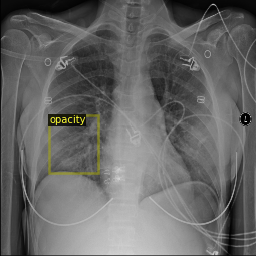

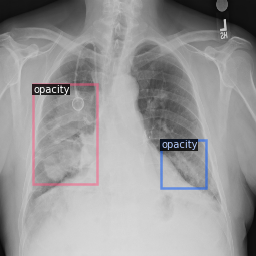

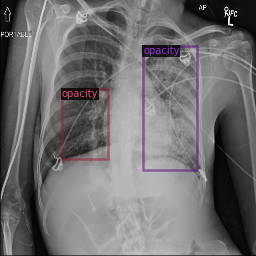

In [ ]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=CXR_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

we can change settings like LR or iterations here to get better performance.

We train detectron2 with two different baselines:

1.   RetinaNet
2.   FasterRCNN

and then we compare the results.




In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))


cfg.DATASETS.TRAIN = ("CXR_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Let training initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)



cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.OUTPUT_DIR = './output_RCNN'
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/08 08:49:02 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[12/08 08:49:07 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/08 08:49:26 d2.utils.events]:  eta: 0:07:27  iter: 19  total_loss: 0.9123  loss_cls: 0.6235  loss_box_reg: 0.1607  loss_rpn_cls: 0.1099  loss_rpn_loc: 0.01746  time: 0.9210  data_time: 0.0184  lr: 9.7405e-06  max_mem: 1827M
[12/08 08:49:43 d2.utils.events]:  eta: 0:06:58  iter: 39  total_loss: 0.9023  loss_cls: 0.5303  loss_box_reg: 0.2508  loss_rpn_cls: 0.1047  loss_rpn_loc: 0.01775  time: 0.8907  data_time: 0.0094  lr: 1.9731e-05  max_mem: 1827M
[12/08 08:50:01 d2.utils.events]:  eta: 0:06:27  iter: 59  total_loss: 0.6538  loss_cls: 0.3814  loss_box_reg: 0.1617  loss_rpn_cls: 0.08495  loss_rpn_loc: 0.01873  time: 0.8806  data_time: 0.0084  lr: 2.972e-05  max_mem: 1827M
[12/08 08:50:18 d2.utils.events]:  eta: 0:06:06  iter: 79  total_loss: 0.7388  loss_cls: 0.3182  loss_box_reg: 0.2859  loss_rpn_cls: 0.07365  loss_rpn_loc: 0.0171  time: 0.8800  data_time: 0.0091  lr: 3.9711e-05  max_mem: 1827M
[12/08 08:50:36 d2.utils.events]:  eta: 0:05:57  iter: 99  total_loss: 0.6113  loss_cls:

In [ ]:
cfg1 = get_cfg()

cfg1.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_1x.yaml"))


cfg1.DATASETS.TRAIN = ("CXR_train",)
cfg1.DATASETS.TEST = ()
cfg1.DATALOADER.NUM_WORKERS = 2


cfg1.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_1x.yaml")  

cfg1.SOLVER.IMS_PER_BATCH = 2
cfg1.SOLVER.BASE_LR = 0.00025
cfg1.SOLVER.MAX_ITER = 500
cfg1.SOLVER.STEPS = []        
cfg1.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   



cfg1.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg1.OUTPUT_DIR = './output_Retina'
os.makedirs(cfg1.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg1) 
trainer.resume_or_load(resume=False)
trainer.train()

Loading config /usr/local/lib/python3.7/dist-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[12/08 09:02:51 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


[12/08 09:02:55 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[12/08 09:03:29 d2.utils.events]:  eta: 0:14:29  iter: 19  total_loss: 1.868  loss_cls: 1.272  loss_box_reg: 0.617  time: 1.7889  data_time: 0.0189  lr: 9.7405e-06  max_mem: 2726M
[12/08 09:03:54 d2.utils.events]:  eta: 0:12:04  iter: 39  total_loss: 1.716  loss_cls: 1.017  loss_box_reg: 0.6377  time: 1.5043  data_time: 0.0091  lr: 1.9731e-05  max_mem: 2726M
[12/08 09:04:19 d2.utils.events]:  eta: 0:09:31  iter: 59  total_loss: 1.078  loss_cls: 0.5592  loss_box_reg: 0.5553  time: 1.4096  data_time: 0.0091  lr: 2.972e-05  max_mem: 2726M
[12/08 09:04:42 d2.utils.events]:  eta: 0:09:02  iter: 79  total_loss: 1.045  loss_cls: 0.5102  loss_box_reg: 0.5132  time: 1.3450  data_time: 0.0092  lr: 3.9711e-05  max_mem: 2726M
[12/08 09:05:05 d2.utils.events]:  eta: 0:08:35  iter: 99  total_loss: 0.9952  loss_cls: 0.4603  loss_box_reg: 0.5148  time: 1.3095  data_time: 0.0093  lr: 4.9701e-05  max_mem: 2726M
[12/08 09:05:28 d2.utils.events]:  eta: 0:07:42  iter: 119  total_loss: 0.8342  loss_cls: 0.3

In [ ]:
#RCNN
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predict_RCNN = DefaultPredictor(cfg)

In [ ]:
#Retina
cfg1.MODEL.WEIGHTS = os.path.join(cfg1.OUTPUT_DIR, "model_final.pth")
cfg1.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   
predictor_Retina = DefaultPredictor(cfg1)

#### Results of Faster-RCNN:

In [ ]:
######
import pandas as pd
metrics_df = pd.read_json("./output_RCNN/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf.head(10).T

,0,1,2,3,4,5,6,7,8,9
data_time,0.007171,0.007291,0.006866,0.008601,0.006941,0.007144,0.006589,0.006745,0.008297,0.007447
eta_seconds,447.492329,418.477463,387.019334,366.321021,357.461218,335.044308,325.831707,305.805864,290.648956,270.483968
fast_rcnn/cls_accuracy,0.804688,0.900391,0.945312,0.919922,0.921875,0.917969,0.876953,0.851562,0.851562,0.839844
fast_rcnn/false_negative,0.727941,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
fast_rcnn/fg_cls_accuracy,0.272059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
iteration,19.000000,39.000000,59.000000,79.000000,99.000000,119.000000,139.000000,159.000000,179.000000,199.000000
loss_box_reg,0.160706,0.250752,0.161676,0.285909,0.296601,0.313067,0.486693,0.561839,0.567285,0.660871
loss_cls,0.623545,0.530271,0.381372,0.318220,0.289679,0.278040,0.350408,0.370908,0.368747,0.358165
loss_rpn_cls,0.109928,0.104686,0.084949,0.073647,0.032388,0.045694,0.040296,0.040218,0.036855,0.034765
loss_rpn_loc,0.017459,0.017746,0.018727,0.017098,0.014541,0.011514,0.014834,0.014162,0.012058,0.011059


#### Results of Retinanet:

In [ ]:
########
import pandas as pd
metrics_df = pd.read_json("./output_Retina/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf.head(10).T

,0,1,2,3,4,5,6,7,8,9
data_time,0.009426,0.007446,0.007679,0.007109,0.008862,0.008071,0.007028,0.007836,0.009674,0.007751
eta_seconds,869.992080,724.388817,571.552633,542.887304,515.520277,462.878659,437.147949,412.237851,387.759955,363.346785
iteration,19.000000,39.000000,59.000000,79.000000,99.000000,119.000000,139.000000,159.000000,179.000000,199.000000
loss_box_reg,0.616985,0.637741,0.555257,0.513169,0.514836,0.451709,0.528960,0.476563,0.476812,0.488992
loss_cls,1.272475,1.017066,0.559201,0.510193,0.460335,0.384606,0.434669,0.388667,0.405844,0.425717
lr,0.000010,0.000020,0.000030,0.000040,0.000050,0.000060,0.000070,0.000080,0.000090,0.000100
num_pos_anchors,46.250000,50.750000,46.500000,48.750000,47.500000,44.750000,52.750000,50.250000,49.000000,47.750000
time,1.812483,1.287472,1.289599,1.208725,1.146682,1.141542,1.145184,1.209853,1.153385,1.208216
total_loss,1.867653,1.715738,1.078183,1.044905,0.995176,0.834199,0.946665,0.907832,0.867254,0.936713


#### Visualize some validation images with their predicted bounding boxes

In [ ]:
val_metadata = MetadataCatalog.get("CXR_val")
val_dataset_dicts = get_CXR_dicts("val")

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


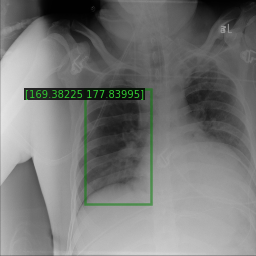

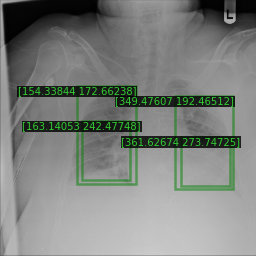

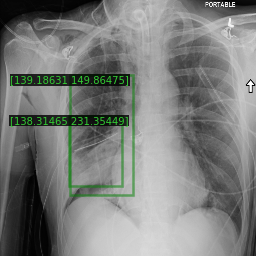

In [ ]:
##### visualize 
# RCNN
for d1 in random.sample(val_dataset_dicts, 3):    
    im1 = cv2.imread(d1["file_name"])
    outputs1 = predict_RCNN(im1)
    v = Visualizer(im1[:, :, ::-1], metadata = val_metadata, scale = 0.5)
    for box in outputs1["instances"].pred_boxes.to('cpu'):
        v.draw_box(box)
        v.draw_text(str(box[:2].numpy()), tuple(box[:2].numpy()))
    v = v.get_output()
    img = v.get_image()[:, :, ::-1]
    cv2_imshow(img)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


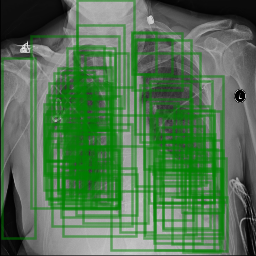

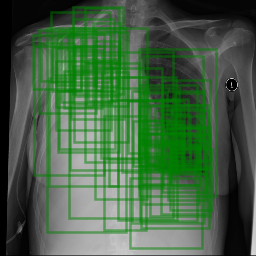

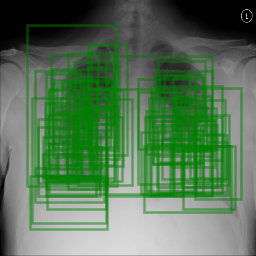

In [ ]:
for d2 in random.sample(val_dataset_dicts, 3):    
    im2 = cv2.imread(d2["file_name"])
    outputs2 = predictor_Retina(im2)
    v1 = Visualizer(im2[:, :, ::-1], metadata = val_metadata, scale = 0.5)
    for box in outputs2["instances"].pred_boxes.to('cpu'):
        v1.draw_box(box)
        #v1.draw_text(str(box[:2].numpy()), tuple(box[:2].numpy()))
    v1 = v1.get_output()
    img1 = v1.get_image()[:, :, ::-1]
    cv2_imshow(img1)

### Inference

In [ ]:
#RCNN
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("CXR_val", output_dir="./output_RCNN")
val_loader = build_detection_test_loader(cfg, "CXR_val")
print(inference_on_dataset(predict_RCNN.model, val_loader, evaluator))

[12/08 08:58:16 d2.evaluation.coco_evaluation]: Trying to convert 'CXR_val' to COCO format ...
[12/08 08:58:16 d2.data.datasets.coco]: Converting annotations of dataset 'CXR_val' to COCO format ...)
[12/08 08:58:16 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[12/08 08:58:16 d2.data.datasets.coco]: Conversion finished, #images: 663, #annotations: 808
[12/08 08:58:16 d2.data.datasets.coco]: Caching COCO format annotations at './output_RCNN/CXR_val_coco_format.json' ...
[12/08 08:58:16 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  opacity   | 808          |
|            |              |
[12/08 08:58:16 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/08 08:58:16 d2.data.common]: Serializing 663 elements to byte tensors and concatenating them all ...
[12/08 08:58:16 d2.d

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[12/08 08:58:20 d2.evaluation.evaluator]: Inference done 11/663. Dataloading: 0.0019 s/iter. Inference: 0.2721 s/iter. Eval: 0.0003 s/iter. Total: 0.2743 s/iter. ETA=0:02:58
[12/08 08:58:25 d2.evaluation.evaluator]: Inference done 30/663. Dataloading: 0.0024 s/iter. Inference: 0.2667 s/iter. Eval: 0.0003 s/iter. Total: 0.2696 s/iter. ETA=0:02:50
[12/08 08:58:30 d2.evaluation.evaluator]: Inference done 49/663. Dataloading: 0.0025 s/iter. Inference: 0.2660 s/iter. Eval: 0.0003 s/iter. Total: 0.2690 s/iter. ETA=0:02:45
[12/08 08:58:35 d2.evaluation.evaluator]: Inference done 68/663. Dataloading: 0.0025 s/iter. Inference: 0.2660 s/iter. Eval: 0.0003 s/iter. Total: 0.2691 s/iter. ETA=0:02:40
[12/08 08:58:40 d2.evaluation.evaluator]: Inference done 87/663. Dataloading: 0.0024 s/iter. Inference: 0.2660 s/iter. Eval: 0.0003 s/iter. Total: 0.2690 s/iter. ETA=0:02:34
[12/08 08:58:45 d2.evaluation.evaluator]: Inference done 106/663. Dataloading: 0.0025 s/iter. Inference: 0.2661 s/iter. Eval: 0.00

In [ ]:
#Retina
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("CXR_val", output_dir="./output_Retina")
val_loader = build_detection_test_loader(cfg1, "CXR_val")
print(inference_on_dataset(predictor_Retina.model, val_loader, evaluator))

[12/08 09:13:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/08 09:13:53 d2.data.common]: Serializing 663 elements to byte tensors and concatenating them all ...
[12/08 09:13:53 d2.data.common]: Serialized dataset takes 0.18 MiB
[12/08 09:13:53 d2.evaluation.evaluator]: Start inference on 663 batches


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[12/08 09:13:57 d2.evaluation.evaluator]: Inference done 11/663. Dataloading: 0.0021 s/iter. Inference: 0.3112 s/iter. Eval: 0.0005 s/iter. Total: 0.3138 s/iter. ETA=0:03:24
[12/08 09:14:02 d2.evaluation.evaluator]: Inference done 28/663. Dataloading: 0.0030 s/iter. Inference: 0.3090 s/iter. Eval: 0.0005 s/iter. Total: 0.3127 s/iter. ETA=0:03:18
[12/08 09:14:08 d2.evaluation.evaluator]: Inference done 45/663. Dataloading: 0.0029 s/iter. Inference: 0.3086 s/iter. Eval: 0.0005 s/iter. Total: 0.3122 s/iter. ETA=0:03:12
[12/08 09:14:13 d2.evaluation.evaluator]: Inference done 61/663. Dataloading: 0.0029 s/iter. Inference: 0.3088 s/iter. Eval: 0.0005 s/iter. Total: 0.3124 s/iter. ETA=0:03:08
[12/08 09:14:18 d2.evaluation.evaluator]: Inference done 78/663. Dataloading: 0.0027 s/iter. Inference: 0.3090 s/iter. Eval: 0.0005 s/iter. Total: 0.3123 s/iter. ETA=0:03:02
[12/08 09:14:23 d2.evaluation.evaluator]: Inference done 94/663. Dataloading: 0.0026 s/iter. Inference: 0.3091 s/iter. Eval: 0.000